In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time

from tqdm import tqdm

#!pip freeze | grep 'matplotlib\|^numpy\|pandas\|seaborn\|tensorflow\|tqdm\|ipython-autotime\|watermark' > requirements.txt

sns.set()
tf.enable_eager_execution()
tf.set_random_seed(1867)


In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

dataset_train = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_train/255, tf.float32),
    tf.cast(y_train, tf.int64)
)).shuffle(1000).batch(64)

dataset_test = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_test/255, tf.float32),
    tf.cast(y_test, tf.int64)
)).batch(64)

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(200, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(10, use_bias=False)
])

In [7]:
optimizer = tf.train.AdamOptimizer()
global_step = tf.train.get_or_create_global_step()

training_losses = []
training_accuracies = []

for epoch in range(10):
    epoch_loss_avg = tf.contrib.eager.metrics.Mean()
    epoch_accuracy = tf.contrib.eager.metrics.Accuracy()
    for x, y in tqdm(dataset_train, total=round(len(x_train)/64)):
        with tf.GradientTape() as tape:
            outputs = model(x)
            loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), outputs)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights), global_step)
        epoch_loss_avg(loss)
        epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
    training_losses.append(epoch_loss_avg.result())
    training_accuracies.append(epoch_accuracy.result())

100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:29<00:00, 32.22it/s]


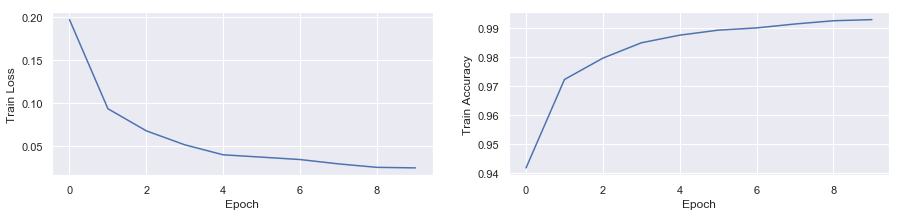

In [8]:
# Plot training curves
plt.figure(1, figsize=(15,3))
plt.subplot(121)
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.subplot(122)
plt.plot(training_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy');

In [9]:
def test(model, dataset):
    epoch_loss_avg = tf.contrib.eager.metrics.Mean()
    epoch_accuracy = tf.contrib.eager.metrics.Accuracy()
    for x, y in dataset:
        outputs = model(x)
        loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), outputs)
        epoch_loss_avg(loss)
        epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
    return epoch_loss_avg.result().numpy(), epoch_accuracy.result().numpy()

test(model, dataset_test)

(0.10114042613807853, 0.9795)

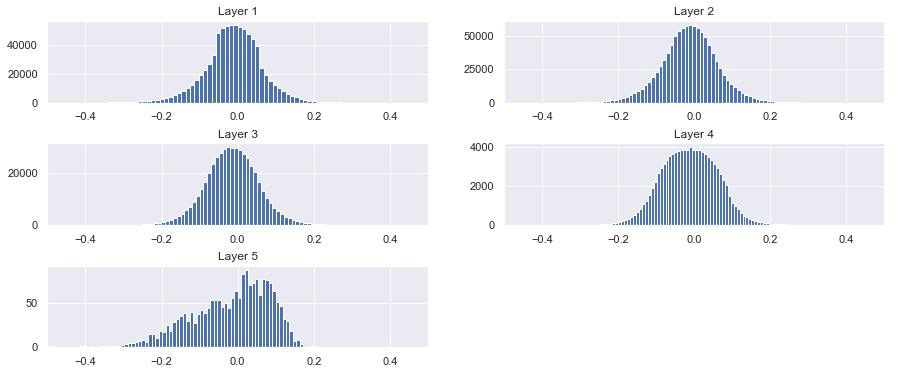

In [10]:
# Plot histogram of each layer's weights (for weight pruning)
plt.figure(1, figsize=(15,6))
plt.subplots_adjust(hspace=0.5)
for i, weights in enumerate(model.trainable_weights):
    plt.subplot(3,2,i+1)
    plt.title("Layer {}".format(i+1))
    plt.hist(weights.numpy().reshape(-1), bins=100)
    plt.xlim(-0.5, 0.5);

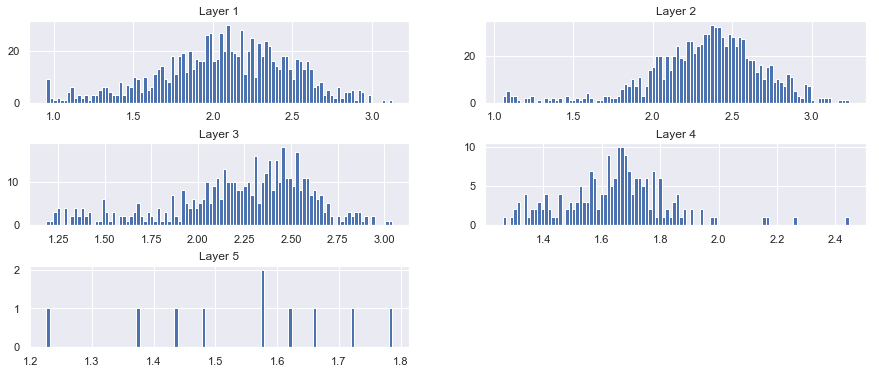

In [11]:
# Plot histogram of each layer's coloumn norms (for unit pruning)
plt.figure(2, figsize=(15,6))
plt.subplots_adjust(hspace=0.5)
for i, weights in enumerate(model.trainable_weights):
    column_norms = np.linalg.norm(weights.numpy(), ord=2, axis=0)
    plt.subplot(3,2,i+1)
    plt.title("Layer {}".format(i+1))
    plt.hist(column_norms, bins=100);

In [13]:
def unit_prune(dense_model, percentile):
    prev_kept_columns = None
    pruned_model = tf.keras.models.Sequential()
    pruned_model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    num_layers = len(dense_model.trainable_weights)

    for i_layer, weights in enumerate(dense_model.trainable_weights):
        weights_np = weights.numpy()
        
        # Remove pruned columns
        if i_layer < num_layers-1: # Do not prune last layer
            column_norms = np.linalg.norm(weights_np, ord=2, axis=0)
            critical_value = np.percentile(column_norms, percentile)
            keep_mask = column_norms >= critical_value
            weights_np = weights_np[:, keep_mask]
            
        # Remove rows corresponding to previous layer's pruned columns
        if prev_kept_columns is not None:
            weights_np = weights_np[prev_kept_columns, :]
        
        # Record which columns were kept
        if i_layer < num_layers-1: # No pruned columns in last layer
            prev_kept_columns = np.argwhere(keep_mask).reshape(-1)
        
        # Add new layer to sparse model
        new_layer = tf.keras.layers.Dense(weights_np.shape[1], activation=tf.nn.relu, use_bias=False)
        pruned_model.add(new_layer)
        new_layer.set_weights([weights_np])

    return pruned_model

test(unit_prune(model, 90), dataset_test) # Sanity check

(2.2603668680616247, 0.5594)

In [14]:
pruned_unit_test_losses = []
pruned_unit_test_accuracies = []
pruned_unit_timings = []

for percentile in percentiles:
    sparse_model = unit_prune(model, percentile)
    t = time.clock()
    l, a = test(sparse_model, dataset_test)
    t = time.clock() - t
    print(f"Pruning p{percentile} -- Test Loss: {l:.4f}, Test Accuracy: {a:.4f}, Timing: {t:.2f}s")
    pruned_unit_test_losses.append(l)
    pruned_unit_test_accuracies.append(a)
    pruned_unit_timings.append(t)

Pruning p0 -- Test Loss: 0.0973, Test Accuracy: 0.9795, Timing: 1.38s
Pruning p25 -- Test Loss: 0.0909, Test Accuracy: 0.9797, Timing: 1.29s
Pruning p50 -- Test Loss: 0.0902, Test Accuracy: 0.9797, Timing: 1.30s
Pruning p60 -- Test Loss: 0.2068, Test Accuracy: 0.9805, Timing: 1.31s
Pruning p70 -- Test Loss: 0.6089, Test Accuracy: 0.9761, Timing: 1.28s
Pruning p80 -- Test Loss: 1.6346, Test Accuracy: 0.9597, Timing: 1.24s
Pruning p90 -- Test Loss: 2.2604, Test Accuracy: 0.5594, Timing: 1.24s
Pruning p95 -- Test Loss: 2.3018, Test Accuracy: 0.2257, Timing: 1.19s
Pruning p97 -- Test Loss: 2.3026, Test Accuracy: 0.0983, Timing: 1.17s
Pruning p99 -- Test Loss: 2.3026, Test Accuracy: 0.0983, Timing: 1.16s


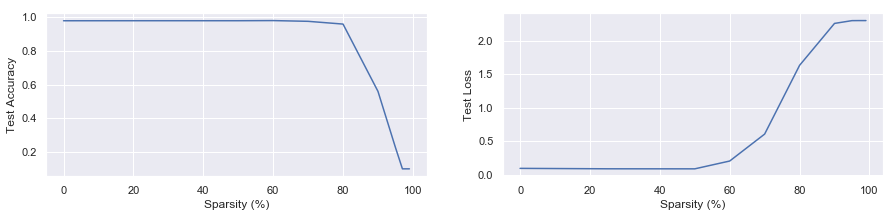

In [15]:
plt.figure(4, figsize=(15,3))
plt.subplot(121)
plt.plot(percentiles, pruned_unit_test_accuracies)
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Accuracy')
plt.subplot(122)
plt.plot(percentiles, pruned_unit_test_losses)
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Loss');

In [16]:
pd.options.display.float_format = '{:.4f}'.format
pd.DataFrame(data={
    'Percent Sparsity':percentiles,
    'Test Accuracy (Unit Pruned)': pruned_unit_test_accuracies,
    'Test Accuracy (Weight Pruned)': pruned_weight_test_accuracies    
})

NameError: name 'pruned_weight_test_accuracies' is not defined